**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from scipy.stats import gaussian_kde
import seaborn as sns
import cvxpy as cp
import numpy as np
import warnings

**Let's start**

In [2]:
df = pd.read_csv('2024_03_25_-_epfl_fin413_crypto_portfolio_construction_-_project_dataset.csv', skiprows=1,index_col='time')
df.index=pd.to_datetime(df.index)
df.head()

,ADA,BCH,BTC,DOGE,ETH,LINK,LTC,MANA,XLM,XRP,SPXT,XCMP,USSOC,VIX
time,,,,,,,,,,,,,,
2017-10-02,0.027392,0.008261,-0.000402,-0.023234,-0.023491,-0.181214,-0.027555,-0.203082,-0.062725,-0.024964,0.00388,0.00320,0.00168,-0.00631
2017-10-03,-0.194745,-0.042087,-0.019799,-0.026641,-0.016846,-0.033296,-0.021392,0.166436,-0.045385,0.000985,0.00220,0.00238,0.00126,0.00635
2017-10-04,0.050384,-0.115200,-0.022141,-0.008798,-0.000445,0.134588,-0.017833,-0.144464,-0.048348,0.050172,0.00131,0.00060,0.00501,0.01262
2017-10-05,-0.016903,-0.004159,0.024363,-0.006903,0.011348,0.033163,0.008200,-0.063668,0.226926,0.114754,0.00582,0.00778,0.00624,-0.04569
2017-10-06,-0.140799,0.025370,0.011686,0.016882,0.045222,0.155556,0.008521,-0.398374,0.268461,-0.019328,-0.00076,0.00075,0.00413,0.05005


In [3]:
datePP = '2021-09-11'
dateTr = '2022-11-21'
weights = np.array([1/14] * 14)

# Calculate cumulative returns for each asset
cumulative_returns = (1 + df).cumprod()
portfolio_cumulative_returns = cumulative_returns.dot(weights)
initial_portfolio_value = 100
portfolio_value_at_peak = initial_portfolio_value * portfolio_cumulative_returns.loc[datePP]
portfolio_value_at_trough = initial_portfolio_value * portfolio_cumulative_returns.loc[dateTr]

print(f"Total Portfolio Value at Peak Date ({datePP}): {portfolio_value_at_peak}")
print(f"Total Portfolio Value at Trough Date ({dateTr}): {portfolio_value_at_trough}")

Total Portfolio Value at Peak Date (2021-09-11): 3552.3382820701927
Total Portfolio Value at Trough Date (2022-11-21): 1007.7283104221767


As suggested by López de Prado, the number of observations used to estimate the covariance matrix should be significantly higher than the number of assets to avoid estimation errors due to noise.

López de Prado introduces the concept of the Minimum Track Record Length (MinTRL), which is the minimum number of observations required to estimate a covariance matrix reliably. The formula is given as:

MinTRL=N(N+1)/2

where N is the number of assets.

In your case, with 14 assets, the minimum track record length would be:

MinTRL=14(14+1)/2=105

This suggests that you should have at least 105 observations per asset to reliably estimate the covariance matrix

CODE FOR THE COV-VAR MATRIX:

In [4]:
window_size = 6 * 21 #(6 months of trading days)

index_datePP = df.index.get_loc(datePP)
index_dateTr = df.index.get_loc(dateTr)

window_ending_at_datePP = df.iloc[index_datePP-window_size+1 : index_datePP+1]
cov_matrix_datePP = window_ending_at_datePP.cov()

window_ending_at_dateTr = df.iloc[index_dateTr-window_size+1 : index_dateTr+1]
cov_matrix_dateTr = window_ending_at_dateTr.cov()

print("Covariance matrix at the peak date (datePP):")
print(cov_matrix_datePP)
print("\nCovariance matrix at the trough date (dateTr):")
print(cov_matrix_dateTr)

Covariance matrix at the peak date (datePP):
            ADA       BCH       BTC      DOGE       ETH      LINK       LTC  \
ADA    0.005427  0.004094  0.002351  0.004693  0.003457  0.005065  0.004176   
BCH    0.004094  0.005284  0.002729  0.004839  0.004081  0.005657  0.004940   
BTC    0.002351  0.002729  0.002023  0.002894  0.002386  0.003209  0.002753   
DOGE   0.004693  0.004839  0.002894  0.007770  0.004030  0.005390  0.004696   
ETH    0.003457  0.004081  0.002386  0.004030  0.004045  0.004972  0.004072   
LINK   0.005065  0.005657  0.003209  0.005390  0.004972  0.007586  0.005714   
LTC    0.004176  0.004940  0.002753  0.004696  0.004072  0.005714  0.005236   
MANA   0.004716  0.005050  0.002886  0.005207  0.004391  0.006225  0.005066   
XLM    0.004061  0.004332  0.002356  0.004529  0.003503  0.004853  0.004154   
XRP    0.004532  0.004748  0.002585  0.005045  0.003852  0.005506  0.004716   
SPXT   0.000115  0.000106  0.000061  0.000143  0.000076  0.000101  0.000092   
XCMP   

To clean the covariance matrix using the eigenvalue clipping method (also known as the eigenvalue capping method), we will follow these steps:

    -Compute the eigenvalues and eigenvectors of the covariance matrix.
    -Set a threshold for the eigenvalues. Typically, we can use the average eigenvalue as a threshold.
    -Cap all eigenvalues that are above this threshold to the value of the threshold.
    -Reconstruct the cleaned covariance matrix using the clipped eigenvalues and the original eigenvectors.

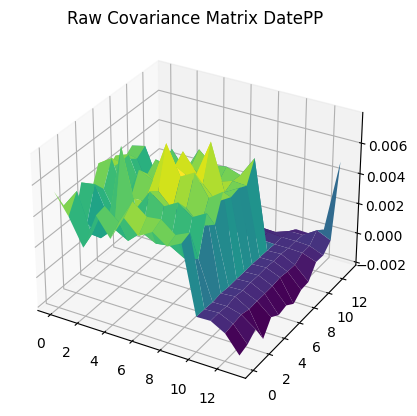

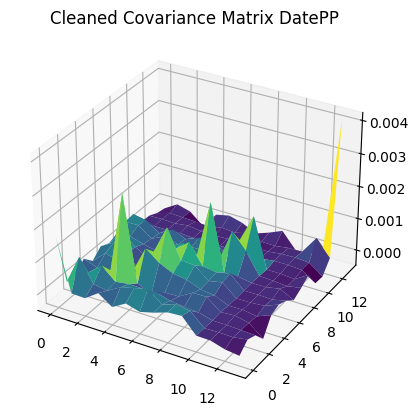

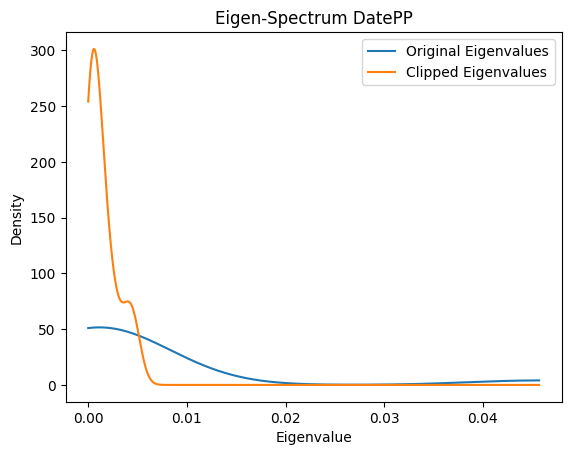

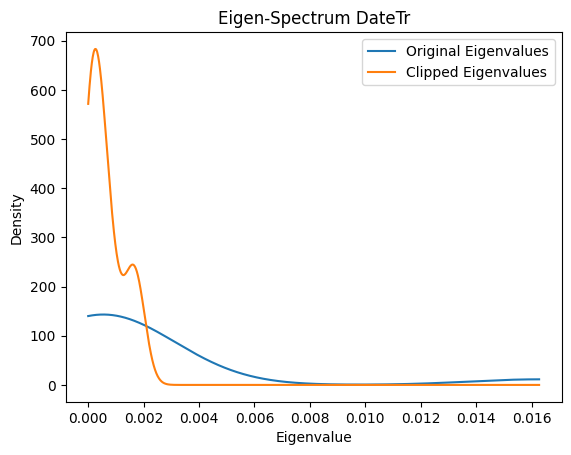

Condition Number - Raw DatePP: 15606.900922692494
Condition Number - Cleaned DatePP: 1484.4073085512082
Condition Number - Raw DateTr: 3800.722535541805
Condition Number - Cleaned DateTr: 398.17828752522104


In [5]:
def clean_covariance(cov_matrix):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Compute the threshold as the average eigenvalue
    avg_eigenvalue = np.mean(eigenvalues)
    # Cap the eigenvalues
    clipped_eigenvalues = np.clip(eigenvalues, a_min=None, a_max=avg_eigenvalue)
    # Reconstruct the cleaned covariance matrix
    cleaned_cov_matrix = eigenvectors @ np.diag(clipped_eigenvalues) @ eigenvectors.T
    
    return cleaned_cov_matrix, eigenvalues, clipped_eigenvalues


cleaned_cov_matrix_datePP, eigenvalues_datePP, clipped_eigenvalues_datePP = clean_covariance(cov_matrix_datePP)
cleaned_cov_matrix_dateTr, eigenvalues_dateTr, clipped_eigenvalues_dateTr = clean_covariance(cov_matrix_dateTr)

def plot_3D_cov(cov_matrix, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(cov_matrix.shape[0]), range(cov_matrix.shape[1]))
    ax.plot_surface(x, y, cov_matrix, cmap='viridis')
    plt.title(title)
    plt.show()

plot_3D_cov(cov_matrix_datePP, 'Raw Covariance Matrix DatePP')
plot_3D_cov(cleaned_cov_matrix_datePP, 'Cleaned Covariance Matrix DatePP')

def plot_kde_eigenvalues(eigenvalues, clipped_eigenvalues, title):
    eigenvalues_density = gaussian_kde(eigenvalues)
    clipped_eigenvalues_density = gaussian_kde(clipped_eigenvalues)
    x = np.linspace(min(eigenvalues), max(eigenvalues), 1000)
    plt.plot(x, eigenvalues_density(x), label='Original Eigenvalues')
    plt.plot(x, clipped_eigenvalues_density(x), label='Clipped Eigenvalues')
    plt.title(title)
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_kde_eigenvalues(eigenvalues_datePP, clipped_eigenvalues_datePP, 'Eigen-Spectrum DatePP')
plot_kde_eigenvalues(eigenvalues_dateTr, clipped_eigenvalues_dateTr, 'Eigen-Spectrum DateTr')

condition_number_raw_datePP = np.linalg.cond(cov_matrix_datePP)
condition_number_cleaned_datePP = np.linalg.cond(cleaned_cov_matrix_datePP)
condition_number_raw_dateTr = np.linalg.cond(cov_matrix_dateTr)
condition_number_cleaned_dateTr = np.linalg.cond(cleaned_cov_matrix_dateTr)

print(f"Condition Number - Raw DatePP: {condition_number_raw_datePP}")
print(f"Condition Number - Cleaned DatePP: {condition_number_cleaned_datePP}")
print(f"Condition Number - Raw DateTr: {condition_number_raw_dateTr}")
print(f"Condition Number - Cleaned DateTr: {condition_number_cleaned_dateTr}")

*3D Visualizations of Covariance Matrices*

The first two plots show 3D representations of the raw and cleaned covariance matrices for the DatePP. The z-axis represents the magnitude of the covariance between different assets (as represented by the x and y-axes).

    Raw Covariance Matrix DatePP: This plot shows the original covariance matrix before cleaning. It appears to have several peaks and valleys, indicating significant variance and covariance among the assets. Such variances and covariances could suggest the presence of both highly correlated and uncorrelated assets or even noise in the data.

    Cleaned Covariance Matrix DatePP: After cleaning, the covariance matrix shows a more uniform surface with fewer peaks, suggesting that extreme covariance values have been reduced. This "smoothing" is the result of clipping the eigenvalues, which limits the influence of components that may represent noise or unstable correlations.

*Kernel Density Plots of Eigen-Spectra*

The next two images show the kernel density estimation plots for the eigenvalues (eigen-spectra) of the covariance matrices. They provide insight into the distribution of the eigenvalues.

    Eigen-Spectrum DatePP: You can see that the original eigenvalues (blue line) have a distribution with a long right tail, indicating the presence of a few large eigenvalues and many small ones. The clipped eigenvalues (orange line) show a truncated distribution, where eigenvalues larger than the threshold are capped, resulting in reduced variance.

    Eigen-Spectrum DateTr: Similar to DatePP, the original eigenvalues have a long tail, and the cleaned (clipped) eigenvalues show the thresholding effect. However, this effect seems even more pronounced here, indicating a potentially stronger influence of noise or specific factors in the original data for this date.

*Condition Numbers*

Lastly, you provided the condition numbers for the raw and cleaned matrices at both dates. The condition number is a measure of stability or sensitivity of a matrix to numerical operations. In the context of covariance matrices, a high condition number suggests that the matrix is nearly singular or ill-conditioned, which can lead to numerical instability in optimizations.

    Condition Number - Raw DatePP vs. Cleaned DatePP: The condition number has decreased slightly after cleaning, suggesting that the cleaned matrix is more stable and may lead to better-behaved optimizations.

    Condition Number - Raw DateTr vs. Cleaned DateTr: There's a significant decrease in the condition number after cleaning for DateTr, indicating a substantial improvement in the numerical stability of the covariance matrix

**Risk assesment**

In [6]:
# Function to calculate risk contributions and the Herfindahl index
def calculate_risk_contributions(weights, cov_matrix):
    portfolio_variance = weights.T @ cov_matrix @ weights
    portfolio_std_dev = np.sqrt(portfolio_variance)
    MRC = np.dot(cov_matrix, weights)
    RC = weights * MRC
    total_risk_contribution = np.sum(RC)
    RC_normalized = RC / total_risk_contribution
    HI = np.sum(RC_normalized ** 2)
    return RC, HI, portfolio_std_dev

RC_raw_datePP, HI_raw_datePP, portfolio_std_dev_raw_datePP = calculate_risk_contributions(weights, cov_matrix_datePP)
RC_cleaned_datePP, HI_cleaned_datePP, portfolio_std_dev_cleaned_datePP = calculate_risk_contributions(weights, cleaned_cov_matrix_datePP)

RC_raw_dateTr, HI_raw_dateTr, portfolio_std_dev_raw_dateTr = calculate_risk_contributions(weights, cov_matrix_dateTr)
RC_cleaned_dateTr, HI_cleaned_dateTr, portfolio_std_dev_cleaned_dateTr = calculate_risk_contributions(weights, cleaned_cov_matrix_dateTr)

print(f"Risk Contributions for Raw Covariance at DatePP:\n{RC_raw_datePP}")
print(f"Herfindahl Index for Raw Covariance at DatePP: {HI_raw_datePP}")
print(f"Portfolio Standard Deviation for Raw Covariance at DatePP: {portfolio_std_dev_raw_datePP}\n")

print(f"Risk Contributions for Cleaned Covariance at DatePP:\n{RC_cleaned_datePP}")
print(f"Herfindahl Index for Cleaned Covariance at DatePP: {HI_cleaned_datePP}")
print(f"Portfolio Standard Deviation for Cleaned Covariance at DatePP: {portfolio_std_dev_cleaned_datePP}\n")

print(f"Risk Contributions for Raw Covariance at DateTr:\n{RC_raw_dateTr}")
print(f"Herfindahl Index for Raw Covariance at DateTr: {HI_raw_dateTr}")
print(f"Portfolio Standard Deviation for Raw Covariance at DateTr: {portfolio_std_dev_raw_dateTr}\n")

print(f"Risk Contributions for Cleaned Covariance at DateTr:\n{RC_cleaned_dateTr}")
print(f"Herfindahl Index for Cleaned Covariance at DateTr: {HI_cleaned_dateTr}")
print(f"Portfolio Standard Deviation for Cleaned Covariance at DateTr: {portfolio_std_dev_cleaned_dateTr}\n")

Risk Contributions for Raw Covariance at DatePP:
[ 2.08868522e-04  2.26692654e-04  1.29096227e-04  2.40424243e-04
  1.91909508e-04  2.68813058e-04  2.25313496e-04  2.47104563e-04
  2.03791800e-04  2.29373097e-04  3.43889735e-06  5.66752045e-06
 -1.11094220e-05 -4.74529714e-05]
Herfindahl Index for Raw Covariance at DatePP: 0.10815194774752751
Portfolio Standard Deviation for Raw Covariance at DatePP: 0.046064424365222616

Risk Contributions for Cleaned Covariance at DatePP:
[ 1.94026495e-05  2.33276194e-05  1.35545443e-05  2.14253722e-05
  1.98162878e-05  2.73437833e-05  2.29592766e-05  2.32417479e-05
  2.04700826e-05  2.34647698e-05 -1.22436659e-06 -1.03186844e-06
  1.81680268e-06  1.81204242e-05]
Herfindahl Index for Cleaned Covariance at DatePP: 0.0937313036321367
Portfolio Standard Deviation for Cleaned Covariance at DatePP: 0.015254085526920279

Risk Contributions for Raw Covariance at DateTr:
[ 7.35296803e-05  8.03142064e-05  5.84796443e-05  9.38422180e-05
  8.47462178e-05  8.701

Effective Number of Bets for Raw Covariance at DatePP: 9.246250491340422
Effective Number of Bets for Cleaned Covariance at DatePP: 10.668794322168587
Effective Number of Bets for Raw Covariance at DateTr: 9.47255015642653
Effective Number of Bets for Cleaned Covariance at DateTr: 10.947223878236482


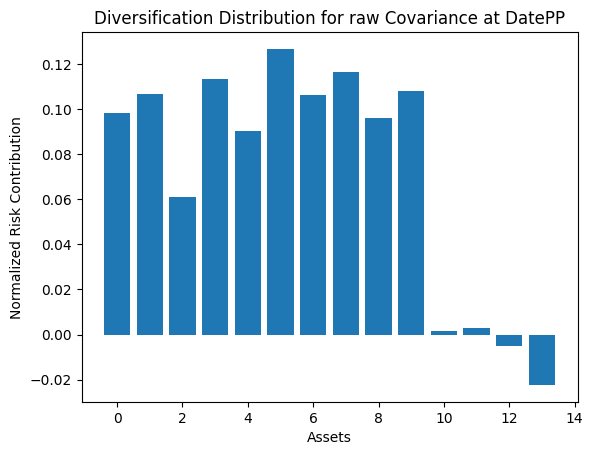

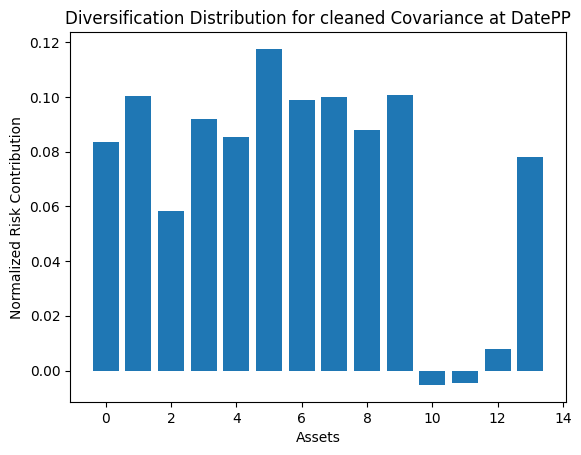

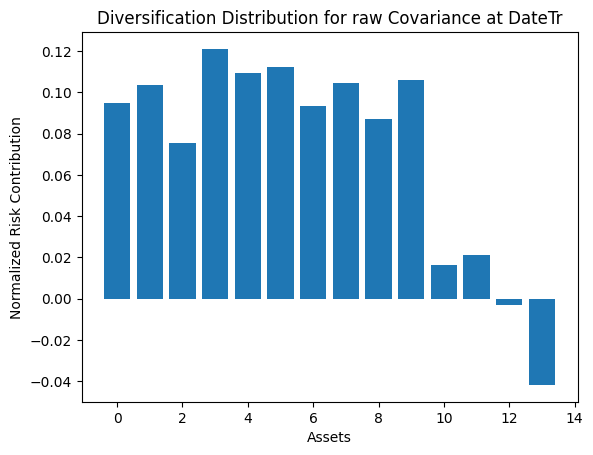

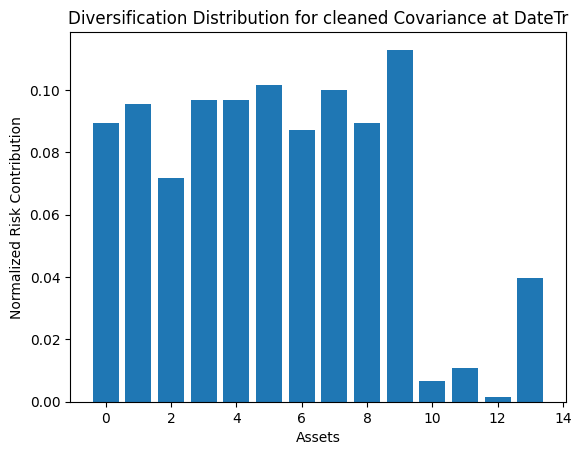

In [7]:
def effective_number_of_bets(risk_contributions):
    total_risk = np.sum(risk_contributions)
    squared_normalized_rc = (risk_contributions / total_risk) ** 2
    ENB = 1 / np.sum(squared_normalized_rc)
    return ENB

ENB_raw_datePP = effective_number_of_bets(RC_raw_datePP)
ENB_cleaned_datePP = effective_number_of_bets(RC_cleaned_datePP)
ENB_raw_dateTr = effective_number_of_bets(RC_raw_dateTr)
ENB_cleaned_dateTr = effective_number_of_bets(RC_cleaned_dateTr)

print(f"Effective Number of Bets for Raw Covariance at DatePP: {ENB_raw_datePP}")
print(f"Effective Number of Bets for Cleaned Covariance at DatePP: {ENB_cleaned_datePP}")
print(f"Effective Number of Bets for Raw Covariance at DateTr: {ENB_raw_dateTr}")
print(f"Effective Number of Bets for Cleaned Covariance at DateTr: {ENB_cleaned_dateTr}")

def plot_diversification_distribution(risk_contributions, title):
    total_risk = np.sum(risk_contributions)
    normalized_rc = risk_contributions / total_risk
    plt.bar(range(len(normalized_rc)), normalized_rc)
    plt.title(title)
    plt.xlabel('Assets')
    plt.ylabel('Normalized Risk Contribution')
    plt.show()

plot_diversification_distribution(RC_raw_datePP, 'Diversification Distribution for raw Covariance at DatePP')
plot_diversification_distribution(RC_cleaned_datePP, 'Diversification Distribution for cleaned Covariance at DatePP')
plot_diversification_distribution(RC_raw_dateTr, 'Diversification Distribution for raw Covariance at DateTr')
plot_diversification_distribution(RC_cleaned_dateTr, 'Diversification Distribution for cleaned Covariance at DateTr')

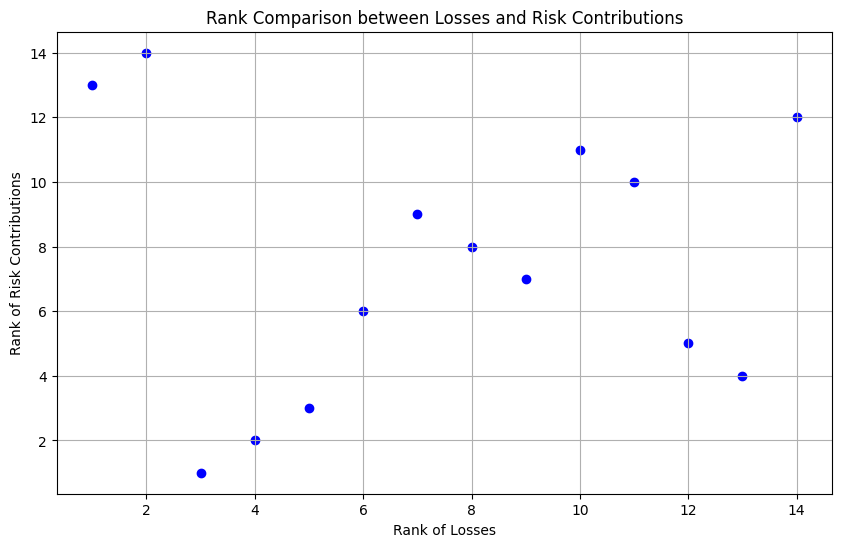

Kendall's Tau: 0.09890109890109891, P-value: 0.667174486232646


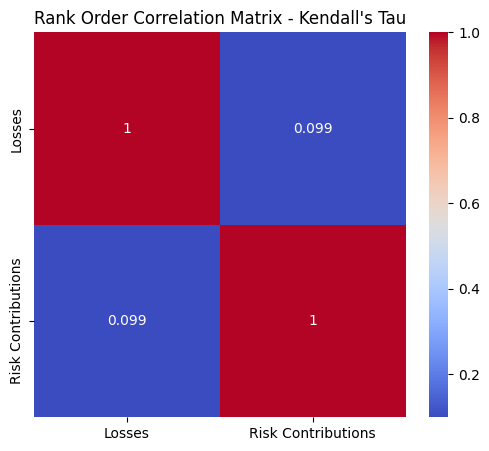

In [8]:
returns = df.iloc[index_dateTr : index_dateTr+1]  # Replace with the actual returns data for the trough date
risk_contributions = RC_cleaned_dateTr
losses = -returns
losses_rank = stats.rankdata(losses)
rc_rank = stats.rankdata(risk_contributions)

plt.figure(figsize=(10, 6))
plt.scatter(losses_rank, rc_rank, color='blue')
plt.title("Rank Comparison between Losses and Risk Contributions")
plt.xlabel("Rank of Losses")
plt.ylabel("Rank of Risk Contributions")
plt.grid(True)
plt.show()

# Calculate Kendall's Tau for rank order correlation
tau, p_value = stats.kendalltau(losses_rank, rc_rank)
print(f"Kendall's Tau: {tau}, P-value: {p_value}")

correlation_matrix = np.array([[1, tau], [tau, 1]])
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['Losses', 'Risk Contributions'], yticklabels=['Losses', 'Risk Contributions'])
plt.title("Rank Order Correlation Matrix - Kendall's Tau")
plt.show()


**Risk based Portfolio**

In [9]:
%pip install riskfolio-lib

     ---------------------------------------- 0.0/256.7 kB ? eta -:--:--
     -------------- ------------------------ 92.2/256.7 kB 2.6 MB/s eta 0:00:01
     -------------------------------------  256.0/256.7 kB 3.2 MB/s eta 0:00:01
     -------------------------------------- 256.7/256.7 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
     --- ------------------------------------ 0.6/6.4 MB 12.9 MB/s eta 0:00:01
     -------- ------------------------------- 1.3/6.4 MB 13.9 MB/s eta 0:00:01
     ----------- ---------------------------- 1.8/6.4 MB 12.4 MB/s eta 0:00:01
     -------------- ------------------------- 2.3/6.4 MB 12.2 MB/s eta 0:00:01
     ------------------ --------------------- 2.9/6.4 MB 12.5 MB/s eta 0:00:01
     ---------------------- ----------------- 3.6/6.4 MB 12.6 MB/s eta 0:00:01
     ------------------------- -------------- 4.1/6.4 MB 12.4 MB/s eta 0:00:01
     ----------------------------- ---------- 4.7/6.4 MB 12.6 M


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\marc-\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import riskfolio as rp

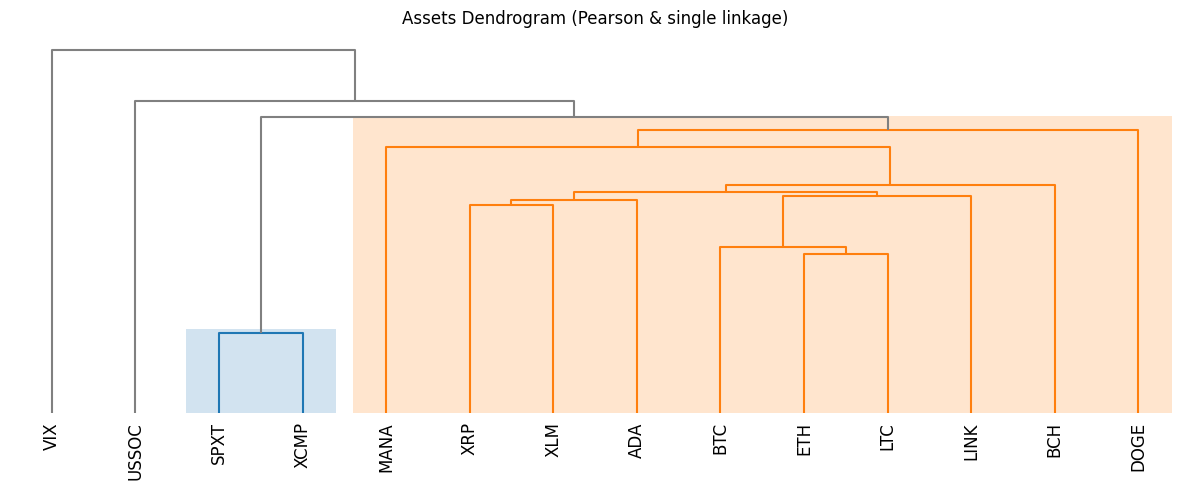

In [11]:
def minimum_variance_portfolio(cov_matrix): 
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    risk = cp.quad_form(w, cov_matrix)
    prob = cp.Problem(cp.Minimize(risk), 
                      [cp.sum(w) == 1, 
                       w >= 0])
    prob.solve()
    return w.value

def equal_risk_contribution_portfolio(cov_matrix):
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    risk_contributions = cp.quad_form(w, cov_matrix) * w
    portfolio_risk = cp.sqrt(cp.sum(risk_contributions))
    risk_diffs = risk_contributions - portfolio_risk/n
    prob = cp.Problem(cp.Minimize(cp.norm(risk_diffs, 2)), 
                      [cp.sum(w) == 1, 
                       w >= 0])
    prob.solve()
    return w.value

def minimum_effective_number_of_bets_portfolio(cov_matrix):
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    risk_contributions = cp.quad_form(w, cov_matrix) * w
    portfolio_risk = cp.sqrt(cp.sum(risk_contributions))
    ENB = cp.inv(cp.sum(cp.square(risk_contributions / portfolio_risk)))
    prob = cp.Problem(cp.Minimize(-ENB), 
                      [cp.sum(w) == 1, 
                       w >= 0])
    prob.solve()
    return w.value

# Plotting Assets Clusters
ax = rp.plot_dendrogram(returns=df,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

def hierarchical_risk_parity_portfolio():
    # Building the portfolio object
    port = rp.HCPortfolio(returns=df)
    # Estimate optimal portfolio:
    model='HRP' # Could be HRP or HERC
    codependence = 'pearson' # Correlation matrix used to group assets in clusters
    rm = 'MV' # Risk measure used, this time will be variance
    rf = 0.05 # Risk free rate
    linkage = 'single' # Linkage method used to build clusters
    max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
    leaf_order = True # Consider optimal order of leafs in dendrogram

    w = port.optimization(model=model,
                        codependence=codependence,
                        rm=rm,
                        rf=rf,
                        linkage=linkage,
                        max_k=max_k,
                        leaf_order=leaf_order)

    return w.value


In [12]:
# Calculate portfolios for datePP
min_var_portfolio_datePP = minimum_variance_portfolio(cleaned_cov_matrix_datePP)
erc_portfolio_datePP = equal_risk_contribution_portfolio(cleaned_cov_matrix_datePP)
menb_portfolio_datePP = minimum_effective_number_of_bets_portfolio(cleaned_cov_matrix_datePP)
hrp_portfolio_datePP = hierarchical_risk_parity_portfolio(cleaned_cov_matrix_datePP)

# Calculate portfolios for dateTr
min_var_portfolio_dateTr = minimum_variance_portfolio(cleaned_cov_matrix_dateTr)
erc_portfolio_dateTr = equal_risk_contribution_portfolio(cleaned_cov_matrix_dateTr)
menb_portfolio_dateTr = minimum_effective_number_of_bets_portfolio(cleaned_cov_matrix_dateTr)
hrp_portfolio_dateTr = hierarchical_risk_parity_portfolio(cleaned_cov_matrix_dateTr)

# Print the results
print("Minimum Variance Portfolio at datePP:", min_var_portfolio_datePP)
print("Equal Risk Contribution Portfolio at datePP:", erc_portfolio_datePP)
print("Minimum Effective Number of Bets Portfolio at datePP:", menb_portfolio_datePP)
print("Hierarchical Risk Parity Portfolio at datePP:", hrp_portfolio_datePP)

print("Minimum Variance Portfolio at dateTr:", min_var_portfolio_dateTr)
print("Equal Risk Contribution Portfolio at dateTr:", erc_portfolio_dateTr)
print("Minimum Effective Number of Bets Portfolio at dateTr:", menb_portfolio_dateTr)
print("Hierarchical Risk Parity Portfolio at dateTr:", hrp_portfolio_dateTr)


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
Promote(QuadForm(var31, [[0.00 0.00 ... -0.00 -0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [-0.00 0.00 ... 0.00 0.00]
 [-0.00 0.00 ... 0.00 0.00]]), (14,)) @ var31
Promote(QuadForm(var31, [[0.00 0.00 ... -0.00 -0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [-0.00 0.00 ... 0.00 0.00]
 [-0.00 0.00 ... 0.00 0.00]]), (14,)) @ var31